In [2]:
%load_ext autoreload
%autoreload 2

import scod
import torch
import numpy as np
from tqdm import trange
from sklearn.datasets import make_moons

import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
class TwoMoonsDataset(torch.utils.data.Dataset):
    """
    Dataset where targets only depend on one of the input dimensions
    We want to ensure we capture uncertainty when deviating even in the insensitive direction
    """
    def __init__(self, N=200, noise=0.2, split='train') -> None:
        super().__init__()
        if split=='train':
            random_state = 1
        elif split == 'val':
            random_state = 2
        else:
            random_state = 3
        X,y = make_moons(n_samples=N, shuffle=True, noise=noise, random_state=random_state)
        self.X = torch.from_numpy(X).float() #+ 5*torch.ones(2)
        self.Y = torch.from_numpy(y).float() 

        self.N = N

    def __len__(self):
        return self.N
    
    def __getitem__(self, idx):
        return (self.X[idx,:], self.Y[idx])

class UniformDataset(torch.utils.data.Dataset):
    def __init__(self, N=500) -> None:
        super().__init__()

        x = -3 + 6*np.random.rand(N*2).reshape([N,2])
        y = x[:,0]
        self.X = torch.from_numpy(x).float()
        self.Y = torch.from_numpy(y).float() 

        self.N = N

    def __len__(self):
        return self.N
    
    def __getitem__(self, idx):
        return (self.X[idx,:], self.Y[idx,None])

In [4]:
# DNN mapping 2d input to 1d distribution parameter
model = torch.nn.Sequential(
    torch.nn.Linear(2, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 2)
)

model[0].requires_grad = False

# create function turning theta (the output of the network) into a distribution object
dist_constructor = lambda theta: scod.distributions.Categorical(logits=theta)

### model training

mean_loss=0.104268: 100%|██████████| 200/200 [00:05<00:00, 36.14it/s]


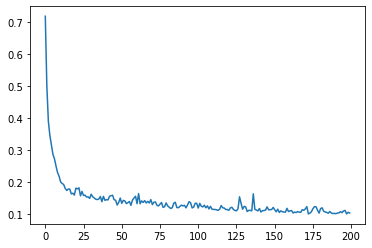

In [5]:
dataset = TwoMoonsDataset()
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

losses = []
t = trange(200)

for epoch in t:
    epoch_loss = 0.
    for (inputs, targets) in train_dataloader:
        optimizer.zero_grad()
        
        outputs = model(inputs)
        dist = dist_constructor(outputs)
        loss = -dist.log_prob(targets)
        mean_loss = loss.mean()

        regularization = torch.sum(torch.stack([torch.norm(p)**2 for p in model.parameters()])) / 1e3

        total_loss = mean_loss + regularization
        total_loss.backward()

        epoch_loss += total_loss
        
        optimizer.step()
        
    epoch_loss /= len(train_dataloader)
    
    t.set_description("mean_loss=%02f"%epoch_loss.item())
    losses.append(epoch_loss.item())

plt.plot(losses)

In [6]:
unc_model = scod.SCOD(model, dist_constructor, args={
    'num_eigs': 50,
    'num_samples': 304,
    'sketch_type': 'srft',
})

Weight space dimension: 1.293e+04


### process training dataset to compute posterior uncertainty

In [7]:
unc_model.process_dataset(dataset)

computing basis
using T = 304


### use validation dataset to optimize prior variance

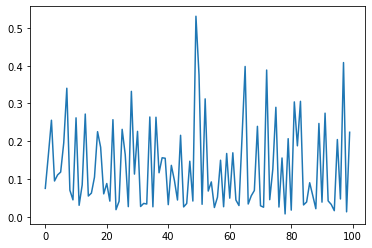

In [8]:
val_dataset = TwoMoonsDataset(split='val')
loss_curve = unc_model.optimize_prior_scale_by_nll(val_dataset, num_epochs=10)
plt.plot(loss_curve)

In [9]:
val_optim_prior = unc_model.log_prior_scale

## regularize w GP

In [10]:
gp_reg_unc_model = scod.SCOD(model, dist_constructor, args={
    'num_eigs': 50,
    'num_samples': 304,
    'sketch_type': 'srft',
    'prior_type': 'per_weight',
})

Weight space dimension: 1.293e+04


In [11]:
def GP_kernel(inputs):
    sq_dist = torch.norm( (inputs[:,None,:] - inputs[None,:,:]), dim=-1 )**2
    length_scale = 0.2
    kernel = torch.exp(- sq_dist / length_scale)
    kernel = torch.kron(kernel, torch.eye(2)) # repeat over output dim to get (2N x 2N) kernel matrix
    return kernel

def GP_mu(x):
    return torch.zeros_like(x)
    
uniform_dataset = UniformDataset()
gp_reg_unc_model.log_prior_scale.data *= 0
loss_curve, min_eigs = gp_reg_unc_model.optimize_prior_scale_by_GP_kernel(uniform_dataset, GP_kernel, GP_mu, num_epochs=30, batch_size=10)

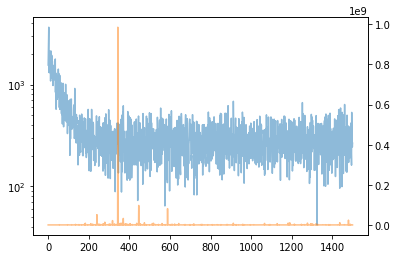

In [12]:
fig, ax = plt.subplots()
ax.semilogy(loss_curve, alpha=0.5)
ax2 = ax.twinx()
ax2.plot(1./np.array(min_eigs), color='C1', alpha=0.5)

In [13]:
gp_reg_unc_model.process_dataset(dataset)

computing basis
using T = 304


In [14]:
gp_reg_unc_model_2 = scod.SCOD(model, dist_constructor, args={
    'num_eigs': 50,
    'num_samples': 304,
    'sketch_type': 'srft',
    'prior_type': 'per_weight',
})

Weight space dimension: 1.293e+04


In [15]:
uniform_dataset = UniformDataset()
gp_reg_unc_model_2.log_prior_scale.data *= 0
loss_curve, min_eigs = gp_reg_unc_model_2.optimize_prior_scale_by_GP_kernel(uniform_dataset, GP_kernel, GP_mu, num_epochs=30, batch_size=10, dist_loss='rev_kl')

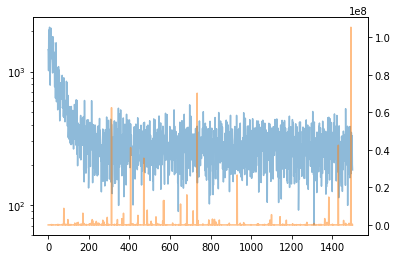

In [16]:
fig, ax = plt.subplots()
ax.semilogy(loss_curve, alpha=0.5)
ax2 = ax.twinx()
ax2.plot(1./np.array(min_eigs), color='C1', alpha=0.5)

In [17]:
gp_reg_unc_model_2.process_dataset(dataset)

computing basis
using T = 304


### compare SCOD's predictions to the original trained model

In [18]:
settings = [
    {   
        'name': 'Unit Prior',
        'model': unc_model,
        'prior_scales': 0*unc_model.log_prior_scale,
    },
    {   
        'name': 'Val Optimized Prior',
        'model': unc_model,
        'prior_scales': None,
    },
    {   
        'name': 'GP Optimized Prior',
        'model': gp_reg_unc_model,
        'prior_scales': None,
    },
    {   
        'name': 'GP Optimized Prior 2',
        'model': gp_reg_unc_model_2,
        'prior_scales': None,
    },
]

In [19]:
X1,X2 = np.meshgrid( np.linspace(-5.,5.,50), np.linspace(-5.,5.,50) )
X = np.stack([X1,X2], axis=-1)
xx_tensor = torch.from_numpy(X).view(-1,2).float()
yhat = model(xx_tensor)
yhat = torch.softmax( model(xx_tensor), -1)
yhat = yhat[:,1].detach().cpu().numpy()

# dists, uncs = unc_model(xx_tensor)
# scod_yhat = np.array([ y.probs[0].detach().cpu().numpy() for y in dists])
# uncs = uncs.detach().cpu().numpy()

In [20]:
results = []
for setting in settings:
    scod_model = setting['model']
    old_prior_scales = scod_model.log_prior_scale.data + 0.
    if setting['prior_scales'] is not None:
        scod_model.log_prior_scale.data = setting['prior_scales']
    
    dists, _ = scod_model(xx_tensor)
    prior_dists, _ = scod_model(xx_tensor, use_prior=True)

    scod_model.log_prior_scale.data = old_prior_scales
    means = np.array( [dist.probs[1].detach().cpu() for dist in dists] ) 
    vars = np.array( [dist.entropy().sum().detach().cpu() for dist in dists] )
    prior_vars = np.array( [dist.entropy().sum().detach().cpu() for dist in prior_dists] )
    result = {
        'name': setting['name'],
        'means': means.reshape(X1.shape),
        'vars': vars.reshape(X1.shape),
        'prior_vars': prior_vars.reshape(X1.shape)
    }
    results.append(result)

Text(0.5, 1.0, 'Posterior Mean')

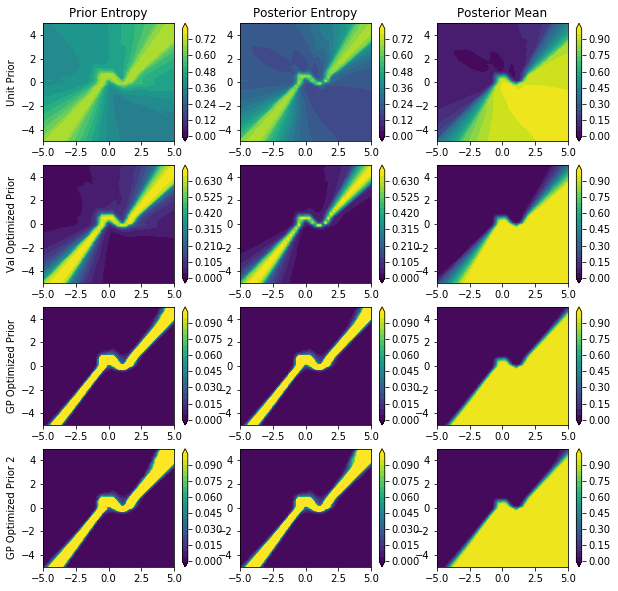

In [21]:
fig, axes = plt.subplots(len(results), 3, figsize=[10,10])
for i, result in enumerate(results):
    max_unc = max(np.round(np.quantile(result['prior_vars'], 0.9) /0.9, decimals=1 ), 0.1)
    levels = np.linspace(0., max_unc, 21)
    
    m = axes[i,0].contourf(X1,X2,result['prior_vars'], vmin=0., vmax=max_unc, extend='both', levels=levels)
    plt.colorbar(m, ax=axes[i,0])

    m = axes[i,1].contourf(X1,X2,result['vars'], vmin=0., vmax=max_unc, extend='both', levels=levels)
    plt.colorbar(m, ax=axes[i,1])

    m = axes[i,2].contourf(X1,X2,result['means'], vmin=0., vmax=1., extend='both', levels=np.linspace(0,1,21))
    plt.colorbar(m, ax=axes[i,2])
    # axes[i,2].scatter(dataset.X[:,0], dataset.X[:,1], c=dataset.Y, vmin=0, vmax=1, edgecolors='k')


    # axes[i,1].scatter(dataset.X[:,0], dataset.X[:,1], marker='+', vmin=-2, vmax=2, color='white', alpha=0.1)
    axes[i,0].set_ylabel(result['name'])

axes[0,0].set_title('Prior Entropy')
axes[0,1].set_title('Posterior Entropy')
axes[0,2].set_title('Posterior Mean')

Text(0.5, 1.0, 'Distribution of per-weight prior variances')

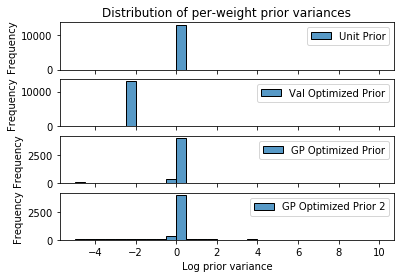

In [22]:
fig, axes = plt.subplots(len(settings),1, sharex=True)

for ax, setting in zip(axes, settings):
    log_prior_scale = setting['model'].log_prior_scale.detach().cpu()
    if setting['prior_scales'] is not None:
        log_prior_scale = setting['prior_scales'].detach().cpu()
    sns.histplot(setting['model']._broadcast_to_n_weights(log_prior_scale), ax=ax, label=setting['name'], binrange=[-5,10], binwidth=0.5)
    ax.legend()
    ax.set_ylabel('Frequency')
    ax.set_xlabel('Log prior variance')

axes[0].set_title('Distribution of per-weight prior variances')
